In [49]:
import collections

import pandas
import numpy
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot

In [2]:
feature_df = pandas.read_table('features/transformed-features.tsv.bz2')
coef_df = pandas.read_table('model/coefficient.tsv')
predict_df = pandas.read_table('predictions/probabilities.tsv')

In [17]:
drop = {'prior_logit', 'intercept'}
coef_df = coef_df.query("feature not in @drop")
coef_df = coef_df.query("coef != 0")
coef_df = coef_df.sort_values('coef')
features = list(coef_df.feature)
subcoef_df = coef_df[(coef_df.feature.str.startswith('dwpc_')) & (coef_df.coef > 0)]
subcoef_df.head(2)

,feature,coef,zcoef
41,dwpc_CbGuDtCpD,0.000345,0.000441
112,dwpc_CuGr>GcGdD,0.001188,0.001769


In [5]:
coef_series = pandas.Series(data=coef_df.coef.tolist(), index=coef_df.feature)
contrib_df = feature_df[coef_df.feature].mul(coef_series, axis='columns')
contrib_df = feature_df[['compound_id', 'disease_id']].join(contrib_df)
contrib_df = predict_df.merge(contrib_df)
contrib_df = contrib_df.sort_values('prediction', ascending=False)

In [6]:
contrib_df.head(2)

,compound_id,compound_name,disease_id,disease_name,category,status,prediction,training_prediction,dwpc_CtDaGiGaD,dwpc_CtDaGaDrD,...,dwpc_CtDrDrDrD,degree_DrD,dwpc_CbGaDrDrD,dwpc_CbGuAlDrD,dwpc_CtDtCtD,dwpc_CbGpPWpGaD,dwpc_CtDrDrD,dwpc_CtDaGaD,degree_DaG,degree_CtD
91496,DB00808,Indapamide,DOID:10763,hypertension,DM,1,0.994276,0.999878,0.519654,0.27547,...,-0.050888,0.014677,0.138279,0.284136,-0.041448,0.594393,-0.119877,-0.259058,2.255991,1.862382
90882,DB00542,Benazepril,DOID:10763,hypertension,DM,1,0.993767,0.999867,0.519654,0.27547,...,-0.050888,0.014677,0.456586,0.136071,-0.041448,0.539915,-0.119877,-0.259058,2.255991,1.862382


In [108]:
pdf = PdfPages('./figure/linear-predictor-plots.pdf')
plot_df = contrib_df.groupby('status').head(10)
for i, row in plot_df.iterrows():
    matplotlib.pyplot.figure(figsize=(5, 15))
    ax = seaborn.barplot(
        x = list(row[list(coef_df.feature)]),
        y = list(coef_df.feature),
        hue = list(numpy.sign(coef_df.coef)))
    ax.set_title('{}–{} · {:.2%} · {}'.format(row['compound_name'], row['disease_name'], row['prediction'], row['category']))
    pdf.savefig(ax.figure, bbox_inches='tight')
    matplotlib.pyplot.close()
pdf.close()

## Extra

In [48]:
# Estimate of percent contribution of each positive term with a positive coefficient
pos_contrib_df = contrib_df[subcoef_df.feature].copy()
pos_contrib_df[pos_contrib_df < 0] = 0
observation_total = pos_contrib_df.sum(axis='columns')
pos_contrib_df = pos_contrib_df.div(observation_total, axis='index')
pos_contrib_df = predict_df.merge(contrib_df[['compound_id', 'disease_id']].join(pos_contrib_df))
#pos_contrib_df.reset_index(inplace=True)
pos_contrib_df.head(2)

,compound_id,compound_name,disease_id,disease_name,category,status,prediction,training_prediction,dwpc_CbGuDtCpD,dwpc_CuGr>GcGdD,...,dwpc_CrCrCtD,dwpc_CtDrD,dwpc_CbGbCtD,dwpc_CtDrDrDrD,dwpc_CbGaDrDrD,dwpc_CbGuAlDrD,dwpc_CtDtCtD,dwpc_CbGpPWpGaD,dwpc_CtDrDrD,dwpc_CtDaGaD
0,DB01048,Abacavir,DOID:10652,Alzheimer's disease,NaN,0,0.000338,0.000457,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.119108,0.0,0.270698
1,DB05812,Abiraterone,DOID:10652,Alzheimer's disease,NaN,0,0.000106,0.000144,0.0,0.0,...,0.0,0.0,0.063159,0.0,0.0,0.0,0.0,0.082451,0.0,0.519200


In [66]:
obj = list()
for i, row in pos_contrib_df.query("prediction > 0.9").iterrows():
    observation = collections.OrderedDict()
    for key in ['compound_id', 'compound_name', 'disease_id', 'disease_name', 'category', 'status', 'prediction', 'training_prediction']:
        observation[key] = row[key]
    if pandas.isnull(observation['category']):
        del observation['category']
    contribs = collections.OrderedDict()
    for key in subcoef_df.feature:
        percent_contrib = row[key]
        if percent_contrib == 0:
            continue
        temp, metapath = key.split('_', 1)
        contribs[metapath] = percent_contrib
    observation['metapath_contribution'] = contribs
    obj.append(observation)

len(obj)

140

In [71]:
import json
with open('features/metapaths.json') as read_file:
    metapaths = json.load(read_file)

In [82]:
dwpc_query = metapaths[0]['dwpc_query']
#print(dwpc_query)


pdp_query = dwpc_query.split('RETURN')[0] + \
'''\
RETURN
path,
extract(n in nodes(path)| n.name) AS nodes,
sum(reduce(pdp = 1.0, d in degrees| pdp * d ^ -0.4)) AS PDP
ORDER BY PDP DESC
LIMIT 10
'''
print(pdp_query)

MATCH path = (n0:Compound)-[:BINDS_CbG]-(n1)-[:ASSOCIATES_DaG]-(n2:Disease)
USING JOIN ON n1
WHERE n0.identifier = { source }
AND n2.identifier = { target }
WITH
[
size((n0)-[:BINDS_CbG]-()),
size(()-[:BINDS_CbG]-(n1)),
size((n1)-[:ASSOCIATES_DaG]-()),
size(()-[:ASSOCIATES_DaG]-(n2))
] AS degrees, path
RETURN
path,
extract(n in nodes(path)| n.name) AS nodes,
sum(reduce(pdp = 1.0, d in degrees| pdp * d ^ -0.4)) AS PDP
ORDER BY PDP DESC
LIMIT 10



In [67]:
obj[1]

OrderedDict([('compound_id', 'DB00989'),
             ('compound_name', 'Rivastigmine'),
             ('disease_id', 'DOID:10652'),
             ('disease_name', "Alzheimer's disease"),
             ('category', 'DM'),
             ('status', 1),
             ('prediction', 0.9388435949349259),
             ('training_prediction', 0.9540225686110021),
             ('metapath_contribution',
              OrderedDict([('CuGr>GcGdD', 0.0008063398878026225),
                           ('CpDrDpCpD', 0.07954357919270055),
                           ('CuGuCbGaD', 0.026080198243017737),
                           ('CcSEcCtDrD', 0.010136021196934407),
                           ('CpDrDrD', 0.09949245802807377),
                           ('CpDpCtD', 0.2373102065580917),
                           ('CuGcG<rGdD', 0.04366408280880132),
                           ('CbGaDdGdD', 0.04505382820710357),
                           ('CbGaD', 0.08524214538445365),
                           ('CbGbCdGaD', 0

In [22]:
contrib_df.query("disease_name == 'multiple sclerosis'").head(5)

,compound_id,compound_name,disease_id,disease_name,category,status,prediction,training_prediction,dwpc_CtDaGiGaD,dwpc_CtDaGaDrD,...,dwpc_CtDrDrDrD,degree_DrD,dwpc_CbGaDrDrD,dwpc_CbGuAlDrD,dwpc_CtDtCtD,dwpc_CbGpPWpGaD,dwpc_CtDrDrD,dwpc_CtDaGaD,degree_DaG,degree_CtD
125177,DB08868,Fingolimod,DOID:2377,multiple sclerosis,DM,1,0.739045,0.924559,0.519654,0.275470,...,-0.050888,-0.283016,0.016686,0.161171,-0.041448,0.771636,-0.119877,-0.259058,1.203603,1.862382
125247,DB05260,Gallium nitrate,DOID:2377,multiple sclerosis,NaN,0,0.192758,NaN,0.519654,0.275470,...,-0.050888,-0.283016,0.375696,0.223954,-0.041448,0.669331,-0.119877,-0.259058,1.203603,-0.977233
125467,DB04835,Maraviroc,DOID:2377,multiple sclerosis,NaN,0,0.156203,NaN,0.519654,0.275470,...,-0.050888,-0.283016,0.287331,-0.199273,-0.041448,0.513572,-0.119877,-0.259058,1.203603,-0.977233
125187,DB01073,Fludarabine,DOID:2377,multiple sclerosis,NaN,0,0.107412,0.535384,-2.984677,0.003628,...,-0.050888,-0.283016,-0.154246,-0.097760,1.482321,0.091307,-0.119877,1.435939,1.203603,3.673735
124635,DB00288,Amcinonide,DOID:2377,multiple sclerosis,NaN,0,0.094903,NaN,0.519654,0.275470,...,-0.050888,-0.283016,-0.154246,-0.199273,-0.041448,0.269062,-0.119877,-0.259058,1.203603,-0.977233


In [8]:
import seaborn
import matplotlib.pyplot
%matplotlib inline

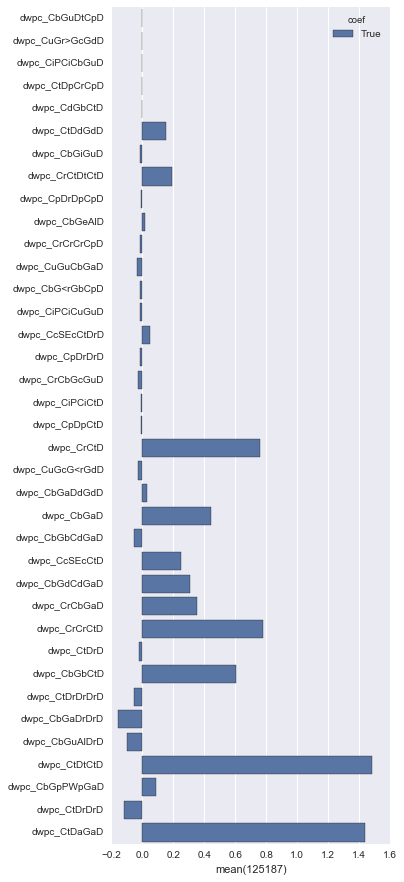

In [23]:
matplotlib.pyplot.figure(figsize=(5, 15))
seaborn.barplot(x = contrib_df.loc[125187, list(subcoef_df.feature)], y = list(subcoef_df.feature), hue = subcoef_df.coef > 0)

In [ ]:
# matplotlib.pyplot.figure(figsize=(5, 15))
# seaborn.barplot(x = contrib_df.loc[125177, dwpcs], y = dwpcs, hue = coef_df.query("feature in @dwpcs").coef > 0)

In [69]:
# matplotlib.pyplot.figure(figsize=(5, 15))
# seaborn.barplot(x = contrib_df.iloc[10000, :], y = contrib_df.columns, hue = coef_df.coef > 0)

In [ ]:
# For positive coefficients

In [24]:
print("MATCH path = (n0:Compound)-[:TREATS_CtD]-(n1)-[:ASSOCIATES_DaG]-(n2)-[:ASSOCIATES_DaG]-(n3:Disease)\nUSING JOIN ON n1\nWHERE n0.identifier = { source }\nAND n3.identifier = { target }\nAND n1 <> n3\nWITH\n[\nsize((n0)-[:TREATS_CtD]-()),\nsize(()-[:TREATS_CtD]-(n1)),\nsize((n1)-[:ASSOCIATES_DaG]-()),\nsize(()-[:ASSOCIATES_DaG]-(n2)),\nsize((n2)-[:ASSOCIATES_DaG]-()),\nsize(()-[:ASSOCIATES_DaG]-(n3))\n] AS degrees, path\nRETURN\ncount(path) AS PC,\nsum(reduce(pdp = 1.0, d in degrees| pdp * d ^ -{ w })) AS DWPC")

MATCH path = (n0:Compound)-[:TREATS_CtD]-(n1)-[:ASSOCIATES_DaG]-(n2)-[:ASSOCIATES_DaG]-(n3:Disease)
USING JOIN ON n1
WHERE n0.identifier = { source }
AND n3.identifier = { target }
AND n1 <> n3
WITH
[
size((n0)-[:TREATS_CtD]-()),
size(()-[:TREATS_CtD]-(n1)),
size((n1)-[:ASSOCIATES_DaG]-()),
size(()-[:ASSOCIATES_DaG]-(n2)),
size((n2)-[:ASSOCIATES_DaG]-()),
size(()-[:ASSOCIATES_DaG]-(n3))
] AS degrees, path
RETURN
count(path) AS PC,
sum(reduce(pdp = 1.0, d in degrees| pdp * d ^ -{ w })) AS DWPC
